plot data in genome-wide

In [1]:
# python modules
import copy
import random
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy
from scipy import stats

In [2]:
# custom modules
import graphics_edit as graphics
import load_file_edit as load_file
import Interval_dict
import statis_edit as statis

In [3]:
# matplotlib setting
%matplotlib inline
mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["axes.facecolor"] = "white"
mpl.rcParams["savefig.facecolor"] = "white"


In [4]:
### parameters
cell_org = {'H1':'human',
            'GM':'human',
            'mCD8T:WT':'mouse',
            'mCD8T:DFMO':'mouse',
            'mCD8T:ODCKO':'mouse'}

cell_chrnames = {'H1':['chr%s' % (i) for i in range(1, 23)] + ['chrX', 'chrY'],
                 'GM':['chr%s' % (i) for i in range(1, 23)] + ['chrX'],
                 'mCD8T:WT':['chr%s' % (i) for i in range(1, 20)] + ['chrX'],
                 'mCD8T:DFMO':['chr%s' % (i) for i in range(1, 20)] + ['chrX'],
                 'mCD8T:ODCKO':['chr%s' % (i) for i in range(1, 20)] + ['chrX']}


In [5]:
agent_fullname = {'sp':'Spermine(4+)',
                  'spd':'Spermidine(3+)',
                  'CoH':'Cobalt Hexammine(3+)',
                  'PEG':'PEG 8000',
                  'HP1a':'HP1$\\alpha$',
                  'HP1bSUV':'HP1$\\beta$+tSUV',
                  'LKH':'Linker histone1',
                  'Ki67':'Ki67',
                  'FUS':'FUS',
                  'Mg':'Magnesium',
                  'Ca':'Calcium'}


In [6]:
### setting data to load
### set data information (fname/field) and key
path = '/Users/sangwoopark/jhu_rockfish/2024_01_05_GEO/processed_files/'

dinfo_dkey = {'mCD8T:WT_NCP_sp_1rep_10kb_sigmoid_4PL.gtab.gz':
              {'Rate':(1, 'WT', 'Rate'),
               'C-half':(1, 'WT', 'Chalf')},
              'mCD8T:DFMO_NCP_sp_1rep_10kb_sigmoid_4PL.gtab.gz':
              {'Rate':(1, 'DFMO', 'Rate'),
               'C-half':(1, 'DFMO', 'Chalf')},
              'mCD8T:ODCKO_NCP_sp_1rep_10kb_sigmoid_4PL.gtab.gz':
              {'Rate':(1, 'ODCKO', 'Rate'),
               'C-half':(1, 'ODCKO', 'Chalf')},
              'mCD8T:WT_NCP_sp_2rep_10kb_sigmoid_4PL.gtab.gz':
              {'Rate':(2, 'WT', 'Rate'),
               'C-half':(2, 'WT', 'Chalf')},
              'mCD8T:DFMO_NCP_sp_2rep_10kb_sigmoid_4PL.gtab.gz':
              {'Rate':(2, 'DFMO', 'Rate'),
               'C-half':(2, 'DFMO', 'Chalf')},
              'mCD8T:ODCKO_NCP_sp_2rep_10kb_sigmoid_4PL.gtab.gz':
              {'Rate':(2, 'ODCKO', 'Rate'),
               'C-half':(2, 'ODCKO', 'Chalf')}}

In [7]:
# data bin size (bp)
bin_size_data = 10000
chr_choices = cell_chrnames['mCD8T:WT']

In [8]:
chr_dkey_ID_value = {}
for fname in dinfo_dkey:
    field_dkey = dinfo_dkey[fname]

    field_chr_ID_value = load_file.read_gtab(path + fname,
                                             field_choices=field_dkey.keys(),
                                             mode='col',
                                             chr_choices=chr_choices,
                                             skip_nan=True,
                                             by_chr=True)

    for field, dkey in field_dkey.items():
        chr_ID_value = field_chr_ID_value[field]
        for chr, ID_value in chr_ID_value.items():
            if chr not in chr_dkey_ID_value:
                chr_dkey_ID_value[chr] = {}
            if dkey not in chr_dkey_ID_value[chr]:
                chr_dkey_ID_value[chr][dkey] = {}
            chr_dkey_ID_value[chr][dkey].update(ID_value)

In [9]:
### read G_banding file
gband_path = './data/'
gband_fname = gband_path + 'Gband_mouse.txt'
chr_GID_Gband = load_file.read_Gband(gband_fname)

In [10]:
### read genome size
ref_path = '/Users/sangwoopark/jhu_rockfish/2024_01_05_GEO/ref_files/'
ref_fname = ref_path + '4D_mm10.fa'
genome_size = load_file.read_genome_size(ref_fname)

In [11]:
### read GTF file
GTF_path = '/Users/sangwoopark/jhu_rockfish/MouseEpigeneticData/GTF/'
GTF_fname = 'ENCFF871VGR.gtf'

geneID_field_value = load_file.read_GTF (GTF_path + GTF_fname,
                                         chr_list=cell_chrnames['mCD8T:WT'])

In [12]:
### read RNA-seq data and compute FPKM
RNAseq_path = '/Users/sangwoopark/jhu_rockfish/MouseEpigeneticData/RNAseq/'
RNAseq_fname = 'GSE136898_rawCounts.txt'

## get mean read counts
exp_gname_counts = load_file.read_tabular_file (RNAseq_path + RNAseq_fname,
                                                mode="col")

gname_counts1 = exp_gname_counts['group4Stim_1']
gname_counts2 = exp_gname_counts['group4Stim_3']

total_counts = 0.0
gname_counts = {}
for gname in gname_counts1:
    counts = (gname_counts1[gname] + gname_counts2[gname])*0.5
    counts += 1  # add pseudo-count
    gname_counts[gname] = counts
    total_counts += counts

## compute exon lengths
geneID_exonlen = {}
for geneID in geneID_field_value:
    exons = geneID_field_value[geneID]['exons']
    length = 0
    for start, end in exons:
        length +=  end - start + 1
    geneID_exonlen[geneID] = length

## compute FPKM
geneID_FPKM = {}
for geneID in geneID_exonlen:
    try:
        gname = geneID_field_value[geneID]['geneName']
        FPM = (gname_counts[gname] / total_counts)*(10**6)
        FPKM = float(FPM)/(geneID_exonlen[geneID]/1000.0)
    except:
        continue
    geneID_FPKM[geneID] = FPKM

In [13]:
### figure parameters
# set figure binning parameters
i = 20
bin_size = int(0.5*(10**6) / i) # binsize (unit of bp)
bin_step = bin_size # no overlap
blur_win = int(4*i + 1) # sliding window (unit of bin)

In [14]:
### binning/smooting the condense-seq data
chr_dkey_sig = {}
for chr in chr_dkey_ID_value:
    for dkey in chr_dkey_ID_value[chr]:
        ID_value = chr_dkey_ID_value[chr][dkey]
        ID_loc = {ID:ID[1:] for ID in ID_value}
        max_pos = genome_size[chr]

        binID_mean = statis.rbin_data_mean(bin_size,
                                           bin_step,
                                           max_pos,
                                           ID_loc,
                                           ID_value,
                                           silent=True)

        sig = [binID_mean[binID] for binID in sorted(binID_mean.keys())]
        sig = statis.slow_moving_average2(sig, blur_win)

        if chr not in chr_dkey_sig:
            chr_dkey_sig[chr] = {}
        chr_dkey_sig[chr][dkey] = sig


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [15]:
### rescale/reorganize the RNA-seq data
chr_geneID_pos = {}
chr_geneID_logFPKM = {}
min_FPKM = min(geneID_FPKM.values())
for geneID in geneID_FPKM:
    try:
        chr = geneID_field_value[geneID]['chr']
        pos = geneID_field_value[geneID]['TSS']
    except:
        continue

    if chr not in chr_geneID_pos:
        chr_geneID_pos[chr] = {}
    chr_geneID_pos[chr][geneID] = pos

    logFPKM = np.log2(geneID_FPKM[geneID] - min_FPKM + 1)
    if chr not in chr_geneID_logFPKM:
        chr_geneID_logFPKM[chr] = {}
    chr_geneID_logFPKM[chr][geneID] = logFPKM
    

In [16]:
### binning/smoothing the RNA-seq data
chr_RNA_sig = {}
for chr in chr_geneID_logFPKM:
    geneID_pos = chr_geneID_pos[chr]
    geneID_logFPKM = chr_geneID_logFPKM[chr]
    max_pos = genome_size[chr]
    binID_mean = statis.rbin_data_mean(bin_size,
                                       bin_step,
                                       max_pos,
                                       geneID_pos,
                                       geneID_logFPKM,
                                       silent=True)
    
    sig = [binID_mean[binID] for binID in sorted(binID_mean.keys())]
    sig = statis.slow_moving_average2(sig, blur_win)
    chr_RNA_sig[chr] = sig


In [17]:
### binning the G-banding data
chr_binID_GID = {}
chr_GID_binwin = {}
for chr in chr_GID_Gband:
    GID_Gband = chr_GID_Gband[chr]

    Int_dict_Gband = Interval_dict.bin_hash(bin_size,
                                            bin_step,
                                            genome_size[chr],
                                            silent=True)
    
    binID_GIDs = {}
    for GID in GID_Gband:
        st, ed = GID_Gband[GID]['interval']
        find_binIDs = Int_dict_Gband.insert_range(st, ed, 1)
        binID_value = Int_dict_Gband.get()
        for binID in find_binIDs:
            if binID not in binID_GIDs:
                binID_GIDs[binID] = []
            binID_GIDs[binID].append((binID_value[binID], GID))
        Int_dict_Gband.clear()

    binID_GID = {}
    GID_binIDs = {}
    for binID, GIDs in binID_GIDs.items():
        GID = sorted(GIDs, reverse=True)[0][1]
        binID_GID[binID] = GID
        if GID not in GID_binIDs:
            GID_binIDs[GID] = []
        GID_binIDs[GID].append(binID)

    GID_binwin = {}
    for GID, binIDs in GID_binIDs.items():
        GID_binwin[GID] = (min(binIDs), max(binIDs))
            
    chr_binID_GID[chr] = binID_GID
    chr_GID_binwin[chr] = GID_binwin

    del Int_dict_Gband, binID_GIDs, GID_binIDs


In [18]:
### make ideogram
chr_Gtype_ideogram = {}
for chr in chr_GID_Gband:
    GID_Gband = chr_GID_Gband[chr]
    Gtype_ideogram = {'num':[], 'var':[], 'acen':[]}
    binID_st, binID_ed = 0, genome_size[chr] / bin_step
    for binID in range(binID_st, binID_ed + 1):
        try:
            GID = chr_binID_GID[chr][binID]
            Gtype = GID_Gband[GID]['type']
            Gvalue = GID_Gband[GID]['value']
        except:
            for key in Gtype_ideogram:
                Gtype_ideogram[key].append([np.nan])
            continue

        if Gtype in ['neg', 'pos']:
            Gtype = 'num'
            assert not np.isnan(Gvalue)
        elif Gtype in ['var', 'acen']:
            Gvalue = 10
        else:
            pass
            
        for key in Gtype_ideogram:
            if key == Gtype:
                Gtype_ideogram[key].append([Gvalue])
            else:
                Gtype_ideogram[key].append([np.nan])

    chr_Gtype_ideogram[chr] = Gtype_ideogram

In [19]:
### set xtick labels along chromosome
chr_xtick_locs = {}
chr_xtick_labels = {}
for chr in chr_choices:
    xtick_locs, xtick_labels = [], []

    binID_st = 0
    binID_ed = genome_size[chr] / bin_step
    for binID in range(binID_st, binID_ed+1):
        pos = bin_step*binID + bin_size/2
        Mb_pos = int(round(float(pos)/(10**6)))

        if Mb_pos % 10 !=0: # 10Mbp steps
            continue

        label = str(Mb_pos)
        if label not in xtick_labels:
            xtick_locs.append(binID)
            xtick_labels.append(label)

    chr_xtick_locs[chr] = xtick_locs
    chr_xtick_labels[chr] = xtick_labels

In [20]:
### set xtick labels for ideogram
chr_Gtick_locs = {}
chr_Gtick_labels = {}
for chr in chr_GID_binwin:
    GID_binwin = chr_GID_binwin[chr]
    Gtick_locs, Gtick_labels = [], []
    for GID in sorted(GID_binwin.keys()):
        binID_st, binID_ed = GID_binwin[GID]
        pos = (binID_st + binID_ed)/2
        Gname = chr_GID_Gband[chr][GID]['name']
        Gtick_locs.append(pos)
        Gtick_labels.append(Gname)
    chr_Gtick_locs[chr] = Gtick_locs
    chr_Gtick_labels[chr] = Gtick_labels

In [21]:
### set heterochromatin regions of ideogram
chr_shade_wins = {}
for chr in chr_GID_binwin:
    GID_binwin = chr_GID_binwin[chr]
    shade_wins = []
    for GID in sorted(GID_binwin.keys()):
        Gtype = chr_GID_Gband[chr][GID]['type']
        if Gtype =='pos':
            shade_wins.append(GID_binwin[GID])
    chr_shade_wins[chr] = shade_wins


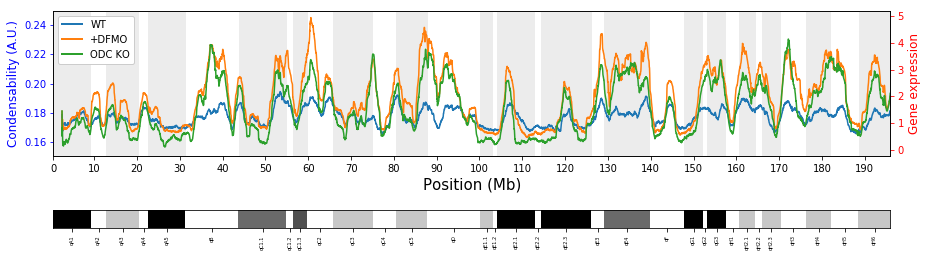

In [25]:
### plot genome-wide data along with ideogram
## figure parameters
side_names = {'left':[(1, 'WT', 'Chalf'),
                      (1, 'DFMO', 'Chalf'),
                      (1, 'ODCKO', 'Chalf')],
              'right':['RNA']}
name_color = {(1, 'WT', 'Chalf'):'tab:blue',
              (1, 'DFMO', 'Chalf'):'tab:orange',
              (1, 'ODCKO', 'Chalf'):'tab:green',
              'RNA':'tab:red'}
name_alpha = {(1, 'WT', 'Chalf'):1,
              (1, 'DFMO', 'Chalf'):1,
              (1, 'ODCKO', 'Chalf'):1,
              'RNA':0}
name_label = {(1, 'WT', 'Chalf'):'WT',
              (1, 'DFMO', 'Chalf'):'+DFMO',
              (1, 'ODCKO', 'Chalf'):'ODC KO'}
side_ylabel={'left':'Condensability (A.U.)',
             'right':'Gene expression'}
side_ycolor={'left':'blue',
             'right':'red'}
side_ylim={'left':[0.15, 0.25],
           'right':None}
#side_ylim={'left':None,
#           'right':None}
side_yscale={'left':None,
             'right':None}

## plot data in genome-wide
for chr in ['chr1']:
    name_sig = chr_dkey_sig[chr]
    name_sig['RNA'] = chr_RNA_sig[chr]
    shade_wins = chr_shade_wins[chr]
    graphics.plot_genome_wide(side_names=side_names,
                              name_sig=name_sig,
                              name_color=name_color,
                              name_alpha=name_alpha,
                              name_label=name_label,
                              side_ylabel=side_ylabel,
                              side_ycolor=side_ycolor,
                              side_ylim=side_ylim,
                              side_yscale=side_yscale,
                              xtick_locs=chr_xtick_locs[chr],
                              xtick_labels=chr_xtick_labels[chr],
                              Gtype_ideogram=chr_Gtype_ideogram[chr],
                              Gtick_locs=chr_Gtick_locs[chr],
                              Gtick_labels=chr_Gtick_labels[chr],
                              shade_wins=shade_wins,
                              fig_width=15,
                              fig_height=4,
                              height_ratios=[8, 1],
                              hspace=0.65,
                              save=False)
    

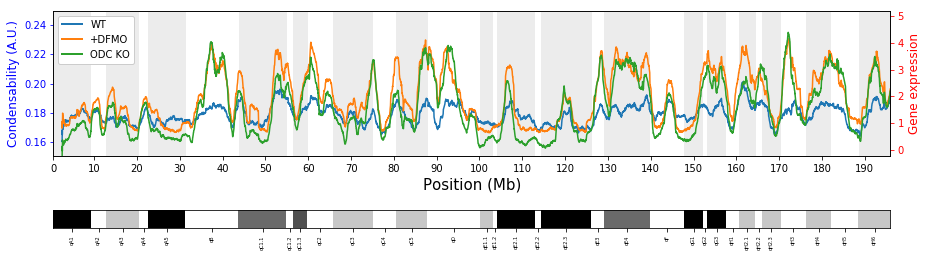

In [26]:
### plot genome-wide data along with ideogram
## figure parameters
side_names = {'left':[(2, 'WT', 'Chalf'),
                      (2, 'DFMO', 'Chalf'),
                      (2, 'ODCKO', 'Chalf')],
              'right':['RNA']}
name_color = {(2, 'WT', 'Chalf'):'tab:blue',
              (2, 'DFMO', 'Chalf'):'tab:orange',
              (2, 'ODCKO', 'Chalf'):'tab:green',
              'RNA':'tab:red'}
name_alpha = {(2, 'WT', 'Chalf'):1,
              (2, 'DFMO', 'Chalf'):1,
              (2, 'ODCKO', 'Chalf'):1,
              'RNA':0}
name_label = {(2, 'WT', 'Chalf'):'WT',
              (2, 'DFMO', 'Chalf'):'+DFMO',
              (2, 'ODCKO', 'Chalf'):'ODC KO'}
side_ylabel={'left':'Condensability (A.U.)',
             'right':'Gene expression'}
side_ycolor={'left':'blue',
             'right':'red'}
side_ylim={'left':[0.15, 0.25],
           'right':None}
#side_ylim={'left':None,
#           'right':None}
side_yscale={'left':None,
             'right':None}

## plot data in genome-wide
for chr in ['chr1']:
    name_sig = chr_dkey_sig[chr]
    name_sig['RNA'] = chr_RNA_sig[chr]
    shade_wins = chr_shade_wins[chr]
    graphics.plot_genome_wide(side_names=side_names,
                              name_sig=name_sig,
                              name_color=name_color,
                              name_alpha=name_alpha,
                              name_label=name_label,
                              side_ylabel=side_ylabel,
                              side_ycolor=side_ycolor,
                              side_ylim=side_ylim,
                              side_yscale=side_yscale,
                              xtick_locs=chr_xtick_locs[chr],
                              xtick_labels=chr_xtick_labels[chr],
                              Gtype_ideogram=chr_Gtype_ideogram[chr],
                              Gtick_locs=chr_Gtick_locs[chr],
                              Gtick_labels=chr_Gtick_labels[chr],
                              shade_wins=shade_wins,
                              fig_width=15,
                              fig_height=4,
                              height_ratios=[8, 1],
                              hspace=0.65,
                              save=False)

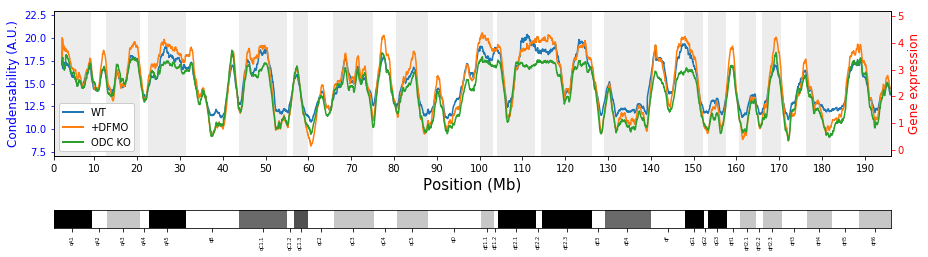

In [27]:
## figure parameters
side_names = {'left':[(1, 'WT', 'Rate'),
                      (1, 'DFMO', 'Rate'),
                      (1, 'ODCKO', 'Rate')],
              'right':['RNA']}
name_color = {(1, 'WT', 'Rate'):'tab:blue',
              (1, 'DFMO', 'Rate'):'tab:orange',
              (1, 'ODCKO', 'Rate'):'tab:green',
              'RNA':'tab:red'}
name_alpha = {(1, 'WT', 'Rate'):1,
              (1, 'DFMO', 'Rate'):1,
              (1, 'ODCKO', 'Rate'):1,
              'RNA':0}
name_label = {(1, 'WT', 'Rate'):'WT',
              (1, 'DFMO', 'Rate'):'+DFMO',
              (1, 'ODCKO', 'Rate'):'ODC KO'}
side_ylabel={'left':'Condensability (A.U.)',
             'right':'Gene expression'}
side_ycolor={'left':'blue',
             'right':'red'}
side_ylim={'left':[7, 23],
           'right':None}
#side_ylim={'left':None,
#           'right':None}
side_yscale={'left':None,
             'right':None}

## plot data in genome-wide
for chr in ['chr1']:
    name_sig = chr_dkey_sig[chr]
    name_sig['RNA'] = chr_RNA_sig[chr]
    shade_wins = chr_shade_wins[chr]
    graphics.plot_genome_wide(side_names=side_names,
                              name_sig=name_sig,
                              name_color=name_color,
                              name_alpha=name_alpha,
                              name_label=name_label,
                              side_ylabel=side_ylabel,
                              side_ycolor=side_ycolor,
                              side_ylim=side_ylim,
                              side_yscale=side_yscale,
                              xtick_locs=chr_xtick_locs[chr],
                              xtick_labels=chr_xtick_labels[chr],
                              Gtype_ideogram=chr_Gtype_ideogram[chr],
                              Gtick_locs=chr_Gtick_locs[chr],
                              Gtick_labels=chr_Gtick_labels[chr],
                              shade_wins=shade_wins,
                              fig_width=15,
                              fig_height=4,
                              height_ratios=[8, 1],
                              hspace=0.65,
                              save=False)

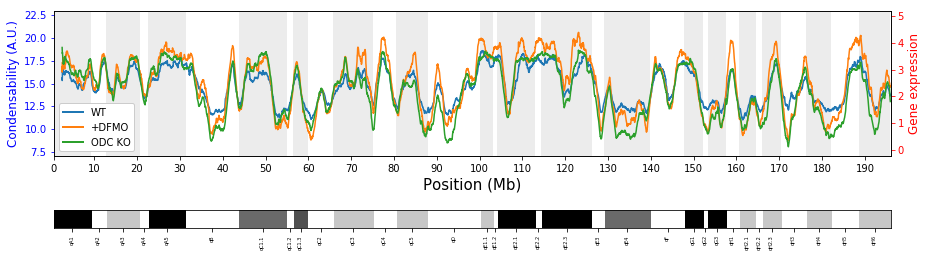

In [28]:
## figure parameters
side_names = {'left':[(2, 'WT', 'Rate'),
                      (2, 'DFMO', 'Rate'),
                      (2, 'ODCKO', 'Rate')],
              'right':['RNA']}
name_color = {(2, 'WT', 'Rate'):'tab:blue',
              (2, 'DFMO', 'Rate'):'tab:orange',
              (2, 'ODCKO', 'Rate'):'tab:green',
              'RNA':'tab:red'}
name_alpha = {(2, 'WT', 'Rate'):1,
              (2, 'DFMO', 'Rate'):1,
              (2, 'ODCKO', 'Rate'):1,
              'RNA':0}
name_label = {(2, 'WT', 'Rate'):'WT',
              (2, 'DFMO', 'Rate'):'+DFMO',
              (2, 'ODCKO', 'Rate'):'ODC KO'}
side_ylabel={'left':'Condensability (A.U.)',
             'right':'Gene expression'}
side_ycolor={'left':'blue',
             'right':'red'}
side_ylim={'left':[7, 23],
           'right':None}
#side_ylim={'left':None,
#           'right':None}
side_yscale={'left':None,
             'right':None}

## plot data in genome-wide
for chr in ['chr1']:
    name_sig = chr_dkey_sig[chr]
    name_sig['RNA'] = chr_RNA_sig[chr]
    shade_wins = chr_shade_wins[chr]
    graphics.plot_genome_wide(side_names=side_names,
                              name_sig=name_sig,
                              name_color=name_color,
                              name_alpha=name_alpha,
                              name_label=name_label,
                              side_ylabel=side_ylabel,
                              side_ycolor=side_ycolor,
                              side_ylim=side_ylim,
                              side_yscale=side_yscale,
                              xtick_locs=chr_xtick_locs[chr],
                              xtick_labels=chr_xtick_labels[chr],
                              Gtype_ideogram=chr_Gtype_ideogram[chr],
                              Gtick_locs=chr_Gtick_locs[chr],
                              Gtick_labels=chr_Gtick_labels[chr],
                              shade_wins=shade_wins,
                              fig_width=15,
                              fig_height=4,
                              height_ratios=[8, 1],
                              hspace=0.65,
                              save=False)